In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [6]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [7]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [8]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D.

#### a) Big gap detection panels

<IPython.core.display.Javascript object>


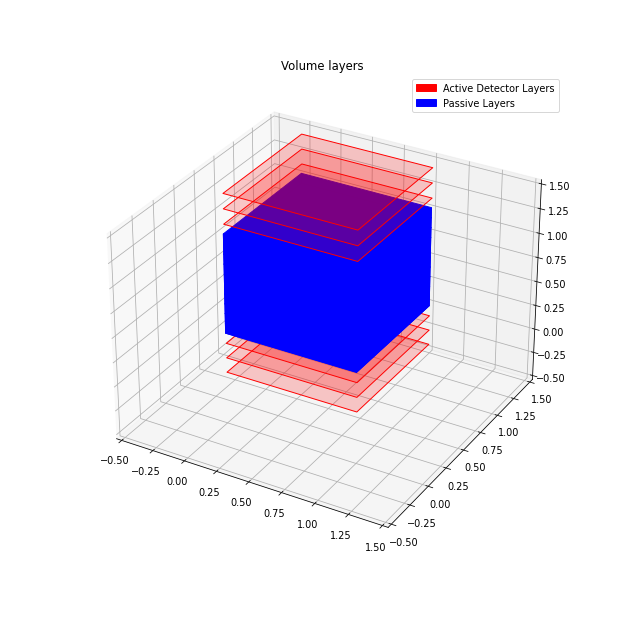

In [9]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### b) Small gap detection panels

<IPython.core.display.Javascript object>


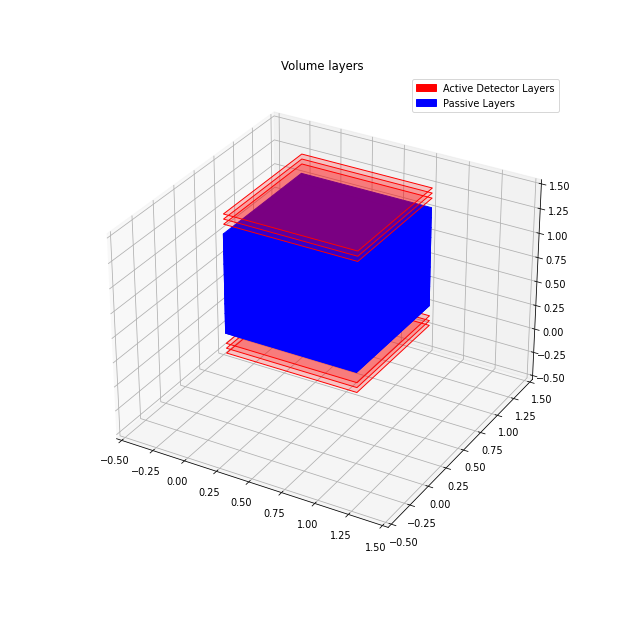

In [10]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### c) Not centred detection panels

<IPython.core.display.Javascript object>


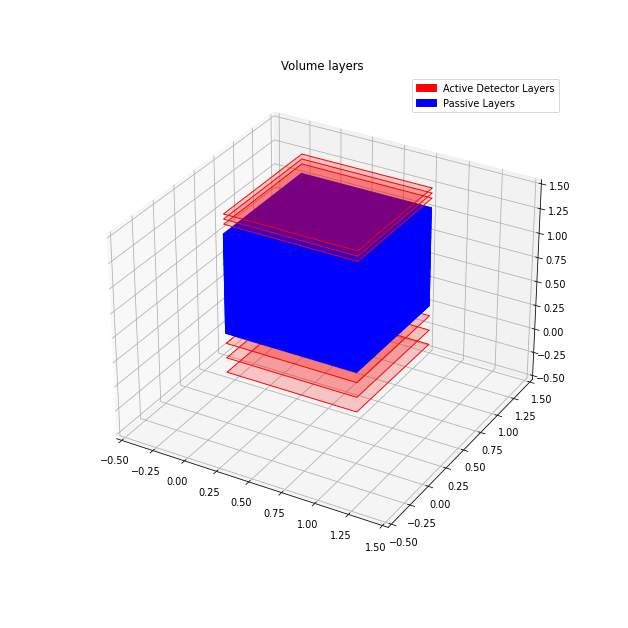

In [11]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [12]:
%matplotlib inline

## **Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is made of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [13]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [14]:
# Choose volume
volume=volume_BigGapHighRes
# volume=volume_BigGap
# volume=volume_SmallGap
# volume=volume_NotCentred

print(volume)
# volume.get_detectors(), volume.get_passives()

passive_gen = LadleFurnacePassiveGenerator(volume)

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We'll generate 10 volumes at a every fill-height. The 10cm of slag will be present for ever volume.

In [15]:
N_PASSIVES_PER_H = 10
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

from tomopt.optimisation import PassiveYielder

trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

This is the amount of passive volumes generated.

In [16]:
len(trn_passives)

80

Let's visualise one of these volume layouts by repurposing one of the visualisers in TomOpt

In [17]:
SelectedVolume = 10
f,t = trn_passives.passives[SelectedVolume]
volume.load_rad_length(f, t)

In [18]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [19]:
from tomopt.plotting import plot_true_x0, plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [20]:
import numpy as np

In [21]:
type(1/np.sqrt(volume.get_rad_cube()))

torch.Tensor

true


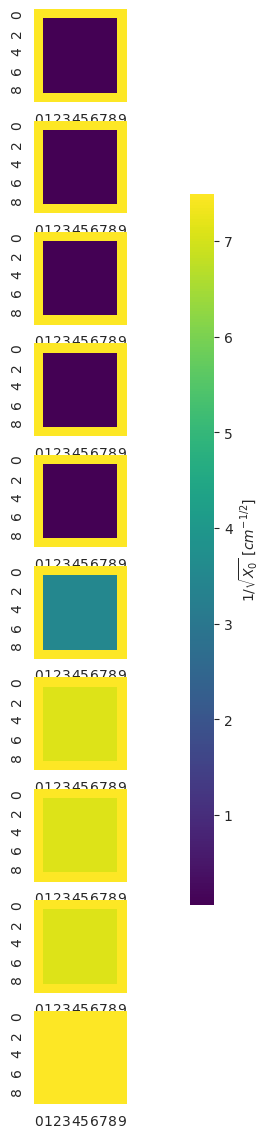

In [22]:
# plot_pred_true_x0(pred=1/np.sqrt(volume.get_rad_cube()), true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X0} \ [cm^{-1/2}]$')
plot_pred_true_x0(true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X_0} \ [cm^{-1/2}]$')


In the plot of the cell above the layers of the ladle can be observed, coloured depending on the X0 of the voxel material:

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

The inverse of the square root of X0 has been plotted, a value which is approximately linear to the material density. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Muon generation and propagation**


In [19]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [20]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [21]:
from tomopt.muon import MuonBatch

In [22]:
muons = MuonBatch(gen(2000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.0237), muons.y[0]=tensor(0.3373), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.5406)'

In [23]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(-0.8090), muons.y[0]=tensor(1.0258), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.5406)'

In [24]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 0.0237,  0.3373,  1.8000],
           [-0.0456,  0.3947,  1.6500],
           [-0.1151,  0.4521,  1.5000]],
  
          [[-0.1077,  1.0847,  1.8000],
           [-0.0901,  1.0238,  1.6500],
           [-0.0726,  0.9628,  1.5000]],
  
          [[ 0.8431,  0.9013,  1.8000],
           [ 0.8354,  0.9495,  1.6500],
           [ 0.8278,  0.9977,  1.5000]],
  
          ...,
  
          [[ 0.9432, -0.0790,  1.8000],
           [ 0.9550, -0.2390,  1.6500],
           [ 0.9669, -0.3968,  1.5000]],
  
          [[ 1.2949,  0.9856,  1.8000],
           [ 1.3873,  0.9044,  1.6500],
           [ 1.4758,  0.8232,  1.5000]],
  
          [[ 0.6738,  1.1355,  1.8000],
           [ 0.5034,  1.0180,  1.6500],
           [ 0.3330,  0.9004,  1.5000]]], grad_fn=<StackBackward0>),
  'gen_xyz': tensor([[[ 0.0237,  0.3373,  1.8000],
           [-0.0457,  0.3947,  1.6500],
           [-0.1151,  0.4521,  1.5000]],
  
          [[-0.1077,  1.0847,  1.8000],
           [-0.09

In [25]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([2000, 3, 3])

In [26]:
from tomopt.inference import ScatterBatch

In [27]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 189 ms, sys: 8.81 ms, total: 198 ms
Wall time: 361 ms


In [28]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 19.1 s, sys: 11.1 s, total: 30.2 s
Wall time: 16.9 s


(tensor([[-0.4375,  0.7187,  0.8030],
         [ 0.0451,  0.5545,  0.4971],
         [ 0.5387,  1.3533,  1.6893],
         ...,
         [ 1.4178,  0.5200,  0.6604],
         [ 1.0840, -1.9644,  0.0199],
         [ 0.0466,  0.7034,  1.2490]], grad_fn=<AddBackward0>),
 tensor([[3.1601e-01, 2.6129e-01, 6.8312e-01],
         [3.0358e-05, 2.6745e-04, 5.4471e-04],
         [3.9564e-01, 1.1897e-01, 8.7119e-01],
         ...,
         [5.6232e-02, 5.5309e-02, 2.3266e-01],
         [2.6954e-02, 3.6048e-01, 3.4035e-01],
         [1.8413e-03, 1.1735e-03, 1.4029e-03]], grad_fn=<SqrtBackward0>))

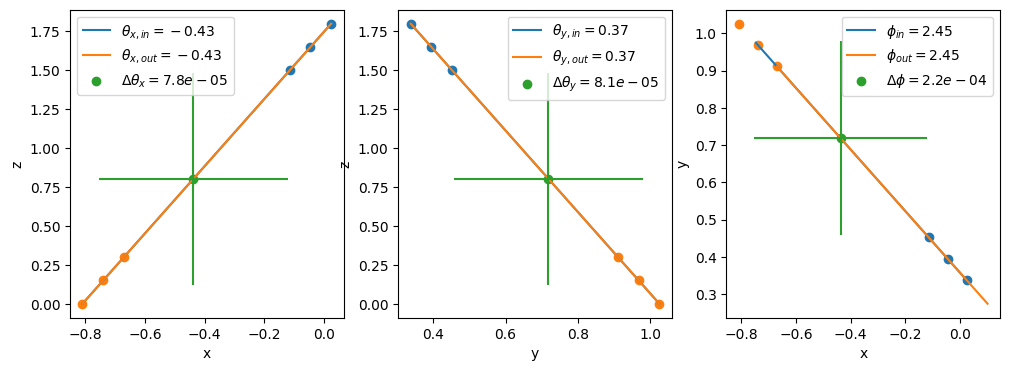

In [29]:
sb.plot_scatter(idx=0)

## **Inference example**

In [30]:
import matplotlib.pyplot as plt

In [31]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 7.0870, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.30000000000000004

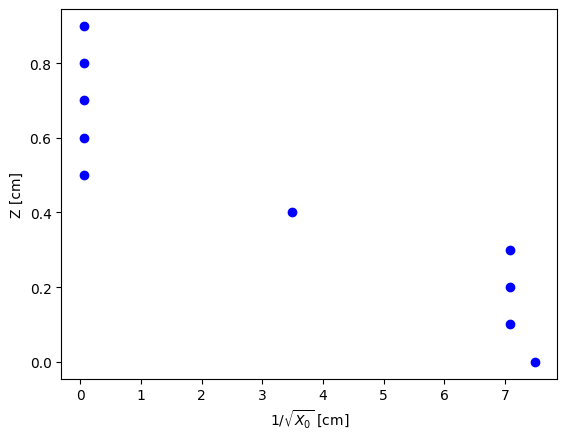

In [32]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [33]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.3335


In [34]:
sb.poca_xyz.detach().cpu().numpy()[:, 0].shape

(1351,)

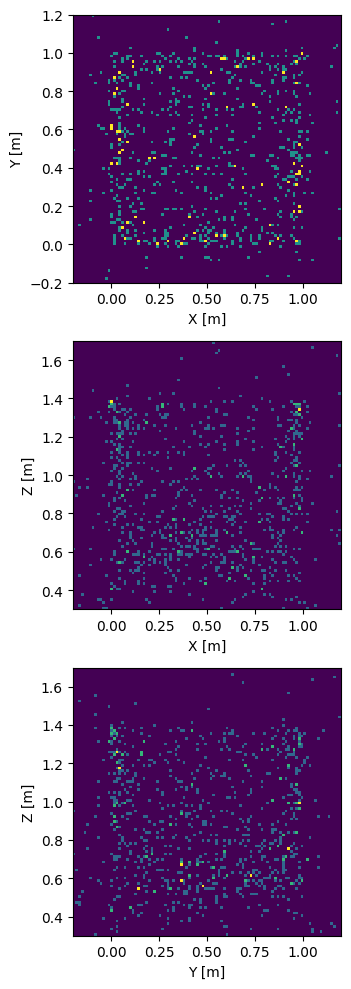

In [35]:
sb.plot_poca_batch(Zlims=[0.5-0.2, 1.5+0.2])

In [36]:
PocaZ

array([0.80304044, 0.4971411 , 1.6892707 , ..., 0.6603595 , 0.01993391,
       1.2489668 ], dtype=float32)

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.2335


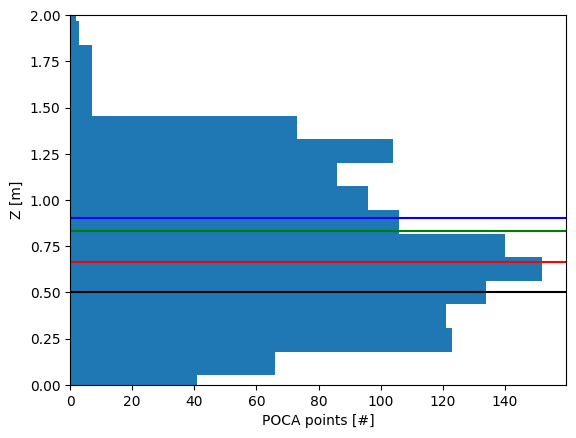

In [37]:
%matplotlib inline

PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
BottomWallThickness = 0.1
SteelLevel_Pred = (np.mean(PocaZ)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(PocaZ), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(PocaZ, bins=200, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()


# Run multiple simulations and get POCA mean, as well as true steel level

In [38]:
len(trn_passives)

80

### Generation

In [39]:
GeneratedMuons = 10000
muons = MuonBatch(gen(10000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(1.4010), muons.y[0]=tensor(0.6164), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.6384)'

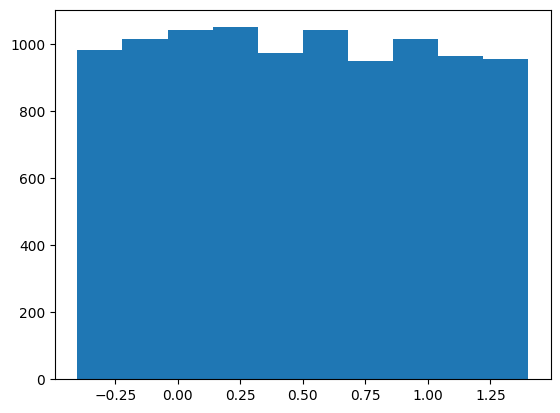

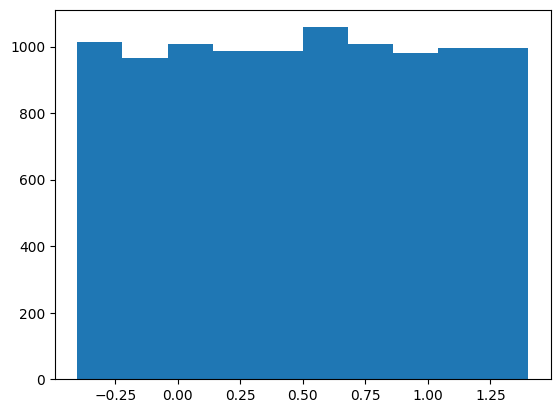

2.25

In [40]:
plt.hist(muons.x)
plt.show()

plt.hist(muons.y)
plt.show()

# Generation surface of 1.5x1.5 m²

1.5*1.5

In [49]:
import sys

def ProgBar(percent, bar_length = 30):  # bar_length should be less than 100
    sys.stdout.write('\r')
    sys.stdout.write("Completed: [{:{}}] {:>3}%"
                     .format('='*int(percent/(100.0/bar_length)),
                             bar_length, int(percent)))
    sys.stdout.flush()

In [113]:
import time
import sys

total = 1007  # total number to reach
bar_length = 30  # should be less than 100
for i in range(total+1):
    percent = 100.0*i/total
    sys.stdout.write('\r')
    sys.stdout.write("Completed: [{:{}}] {:>3}%"
                     .format('='*int(percent/(100.0/bar_length)),
                             bar_length, int(percent)))
    sys.stdout.flush()
    time.sleep(0.002)

Completed: [==============================] 100%

In [50]:
TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

PocaZmeans = np.zeros(len(trn_passives.passives))
PocaZmeans[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    ProgBar(percent=100.0*i/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    PocaZ = sb.poca_xyz[:, 2].detach().numpy()
    PocaZmean = np.mean(PocaZ)
    PocaZmean

    # Get true steel level
    #%matplotlib inline
    #plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
    #plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
    #plt.ylabel("Z [cm]")
    #plt.show()

    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    #%matplotlib inline
    #plt.hist(PocaZ, bins=100, orientation="horizontal")
    #plt.ylim(0,1.8)
    #plt.show()
    
    TrueSteelLevels[i] = SteelLevel_True
    PocaZmeans[i] = PocaZmean
    


Completed: [============================= ]  98%

In [54]:
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/TrueSteelLevels.csv"), TrueSteelLevels)
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/PocaZmeans.csv"), PocaZmeans)


In [63]:
LevelMeans = np.array(np.unique(TrueSteelLevels))


for i in range(len(np.unique(TrueSteelLevels))):
    SteelLevel = np.unique(TrueSteelLevels)[i]
    LevelMeans[i] = np.mean(PocaZmeans[TrueSteelLevels==SteelLevel])

LevelMeans

array([0.69297104, 0.68908713, 0.68490069, 0.70236996, 0.72278107,
       0.71487107, 0.73500607, 0.76551759])

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

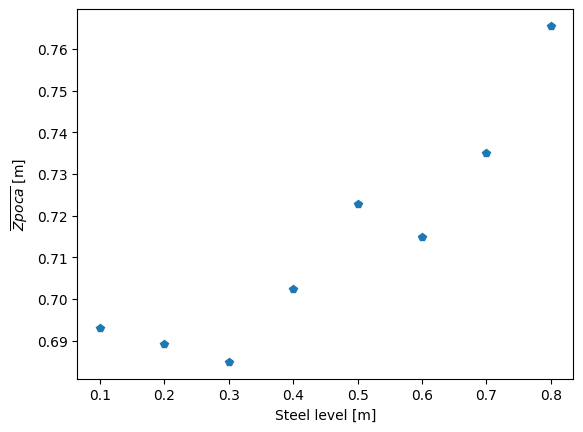

In [66]:
plt.plot(np.unique(TrueSteelLevels), LevelMeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

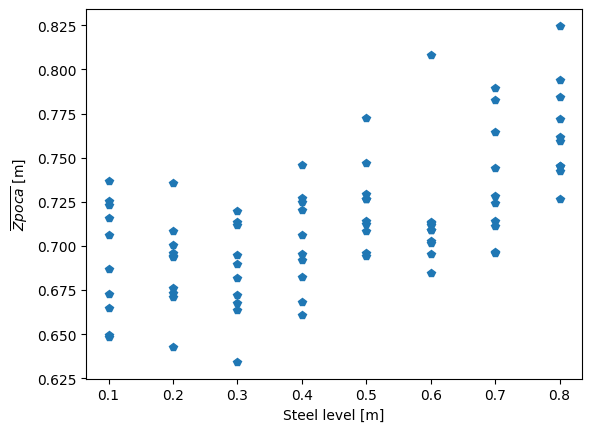

In [51]:
plt.plot(TrueSteelLevels, PocaZmeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

### Zpoca mean increment in very low steel levels. Due to the walls?? Try filtering POCAs out of furnace interior

(array([  1.,   0.,   0.,   0.,   1.,   9.,  77., 481.,  80.,  17.]),
 array([-10.76350975,  -9.25995541,  -7.75640059,  -6.25284576,
         -4.74929094,  -3.24573636,  -1.74218166,  -0.238627  ,
          1.26492763,   2.76848245,   4.27203703]),
 <BarContainer object of 10 artists>)

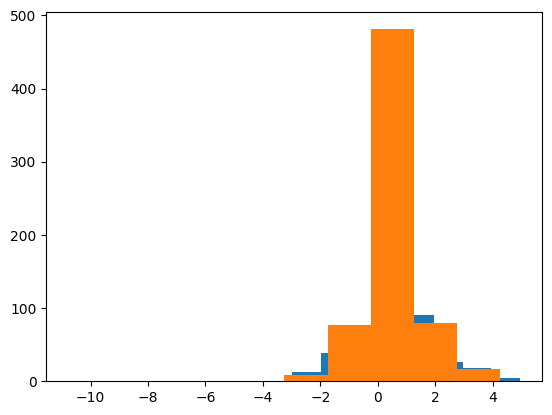

In [77]:
plt.hist(sb.poca_xyz[:, 0].detach().numpy())
plt.hist(sb.poca_xyz[:, 1].detach().numpy())


# Model steel level depending on Zpoca mean (1st, and 2nd order)

# Invert and get inference